# 라이브러리 불러오기

In [34]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import matplotlib.pyplot as plt

# 랜덤 시드 설정

In [35]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [39]:
train_data = pd.read_csv('../../data/data/train.csv')
test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')

# 데이터 전처리하기

In [40]:
# Train
# 날짜순으로 정렬
train_data["contract_year_month_day"] = pd.to_datetime(train_data["contract_year_month"] * 100 + train_data["contract_day"], format='%Y%m%d')
train_data = train_data.sort_values(by="contract_year_month_day")

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)

train_data.shape

(1717611, 12)

# 데이터 EDA 수행하기

In [37]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
# print("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())

train, test_data, sample_submission shape :  (1801228, 11) (150172, 10) (150172, 2)
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.801228e+06  1.801228e+06         1.801228e+06  1.801228e+06   
mean   9.006135e+05  7.518833e+01         2.021331e+05  1.589943e+01   
std    5.199699e+05  2.552632e+01         1.352815e+02  8.625998e+00   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.503068e+05  5.975000e+01         2.020080e+05  9.000000e+00   
50%    9.006135e+05  7.715000e+01         2.021110e+05  1.600000e+01   
75%    1.350920e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   

       contract_type         floor    built_year      latitude     longitude  \
count   1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06   
mean    1.203805e+00  1.005197e+01  2.004199e+03  3.747721e+01  1.269662e+02   


# 대회에 필요한 데이터만 활용하기

In [41]:
# 필요 없는 column 제거
train_data = train_data.drop(columns=["index", "contract_year_month_day"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
train_data["contract_year_month_day"] = train_data["contract_year_month"] * 100 + train_data["contract_day"]
train_data.drop(columns=["contract_year_month", "contract_day"], inplace=True)

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [43]:
holdout_start = 20230701
holdout_end = 20231231
holdout_data = train_data[(train_data['contract_year_month_day'] >= holdout_start) & (train_data['contract_year_month_day'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month_day'] >= holdout_start) & (train_data['contract_year_month_day'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [44]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [55]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 7
[LightGBM] [Info] Start training from score 30826.432533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in th

# Holdout 데이터셋에 대한 성능 확인

In [56]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 5107.40


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

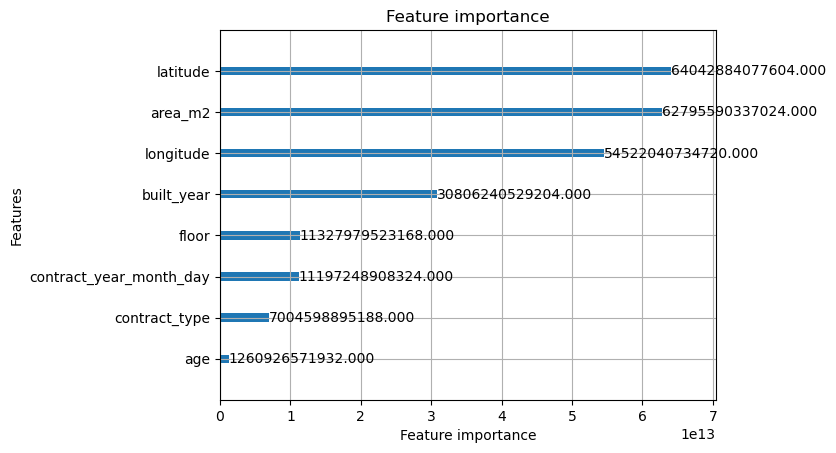

In [57]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)


(-100000.0, 100000.0)

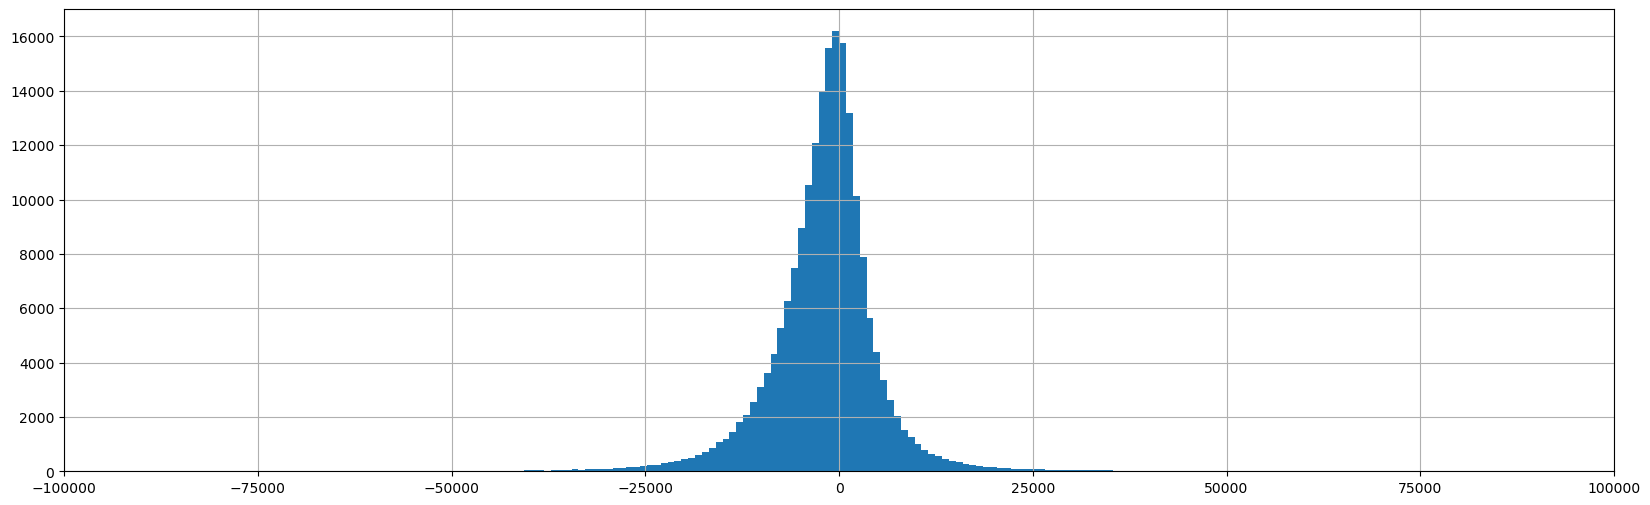

In [58]:
pred_df = pd.DataFrame({'pred': lgb_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df["diff"].hist(bins=800, figsize=(20, 6))
# plt.ylim(0, 80)
plt.xlim(-100000, 100000)

In [59]:
pred_df.describe()

,pred,target,diff
count,198636.000000,198636.000000,198636.000000
mean,38965.849861,40903.631089,-1937.781228
std,26132.586413,28571.795590,8281.949837
min,-49568.480163,955.000000,-496510.616263
25%,22578.669720,23000.000000,-5005.818291
50%,32726.065446,34458.000000,-1361.064650
75%,47717.024292,50000.000000,1484.438145
max,632897.675670,1000000.000000,211529.735657


# Sample Submission 제출하기

In [27]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv(f"output_{datetime.datetime.now().replace(second=0, microsecond=0)}.csv", index=False, encoding='utf-8-sig')